In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob
import tensorflow as tf

In [3]:
!pip install opencv-python

In [3]:
epochs = 100
lr = 1e-3
batch_size = 64
img_dims = (96,96,3)

data = []
labels = []

# load image files from the dataset
image_files = [f for f in glob.glob(r'C:\Users\user\Desktop\Age and Gender\Gender-Detection-master\gender_dataset_face' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

# converting images to arrays and labelling the categories
for img in image_files:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2] # C:\Files\gender_dataset_face\woman\face_1162.jpg
    if label == "woman":
        label = 1
    else:
        label = 0
        
    labels.append([label]) # [[1], [0], [0], ...]

# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)

trainY = to_categorical(trainY, num_classes=2) # [[1, 0], [0, 1], [0, 1], ...]
testY = to_categorical(testY, num_classes=2)

# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")


In [34]:
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1
    
    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first", 
    # set axis=1 in BatchNormalization.

    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))
    model.add(tf.keras.layers.Softmax(axis=-1))
    
    return model


In [41]:
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                            classes=2)

# compile the model
opt = Adam(lr=lr, decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the model
H = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=100, verbose=1)

# save the model to disk
model.save('gender_detection.model')

Epoch 1/100


C:\Users\user\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


28/28 [==============================] - 16s 544ms/step - loss: 0.6138 - accuracy: 0.6766 - val_loss: 0.7448 - val_accuracy: 0.4589
Epoch 2/100
28/28 [==============================] - 16s 553ms/step - loss: 0.5463 - accuracy: 0.7456 - val_loss: 0.8154 - val_accuracy: 0.4589
Epoch 3/100
28/28 [==============================] - 15s 537ms/step - loss: 0.5111 - accuracy: 0.7844 - val_loss: 0.8312 - val_accuracy: 0.4589
Epoch 4/100
28/28 [==============================] - 15s 548ms/step - loss: 0.4948 - accuracy: 0.8114 - val_loss: 0.8538 - val_accuracy: 0.4589
Epoch 5/100
28/28 [==============================] - 16s 584ms/step - loss: 0.4916 - accuracy: 0.8069 - val_loss: 0.8541 - val_accuracy: 0.4589
Epoch 6/100
28/28 [==============================] - 17s 613ms/step - loss: 0.4682 - accuracy: 0.8411 - val_loss: 0.8522 - val_accuracy: 0.4589
Epoch 7/100
28/28 [==============================] - 16s 554ms/step - loss: 0.4574 - accuracy: 0.8456 - val_loss: 0.8544 - val_accuracy: 0.4589
Epoc

INFO:tensorflow:Assets written to: gender_detection.model\assets


INFO:tensorflow:Assets written to: gender_detection.model\assets


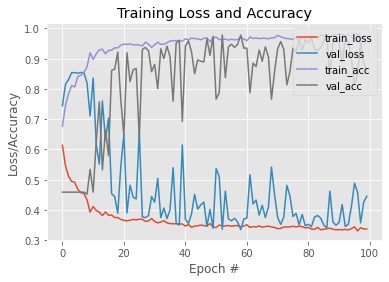

In [42]:
plt.style.use("ggplot")
plt.figure()
N = 100
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# save plot to disk
plt.savefig('plot.png')

In [36]:
from tensorflow.keras.models import load_model
model1 = load_model('gender_detection.model')

In [37]:
test1 = np.array(testX[0], dtype="float") / 255.0

In [38]:
test1 = test1.reshape(1,96,96,3)

In [40]:
#np.argmax(model1.predict(test1)[0])
model1.predict(test1)[0]

1/1 [==============================] - 0s 16ms/step


array([0.6691698, 0.3308302], dtype=float32)